In [1]:
import Attention as AttentionLayer
import numpy as np
import pandas as pd
import re
import pickle
from unicodedata import normalize
import string
import keras
from bs4 import BeautifulSoup

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import warnings
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.initializers import Constant
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
import collections
from datasets import load_dataset

2023-11-06 10:26:31.017753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 10:26:32.022081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-11-06 10:26:32.022186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [11]:
#!pip install tensorflow_addons
#!pip install nltk
#!pip install gensim
#!pip install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/7c/55/b3432f43d6d7fee999bb23a547820d74c48ec540f5f7842e41aa5d8d5f3a/datasets-2.14.6-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/80/8a/1dd41557883b6196f8f092011a5c1f72d4d44cf36d7b67d4a5efe3127949/xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5e6/multiprocess-0.70.15-py310-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0.0,>=0.14.0 from https://files.pythonhosted.org/packages/ef/b5/b6107bd65fa4c96fdf00e4733e2fe5729bb9e5e09997f63074bb43d3ab28/huggingface_hub-0.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonhosted.org/packages/f5/3a/74a29b

In [2]:
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
#using this implementation of attention
#https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def _init_(self, **kwargs):
        super(AttentionLayer, self)._init_(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Preparing Data

In [14]:
def clean_data(text):
    result = []
    # regex for removing weird chars
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # regex for removing punctuation except ':'
    regex_punct = re.compile('[%s]' % re.escape(''.join(c for c in string.punctuation if c != ':')))
    for line in text:
        # unicode chars
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # split on whitespace so we can remove weird chars and punctuation
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation (except ':') and weird chars
        line = [regex_punct.sub('', word) for word in line]
        line = [re_print.sub('', w) for w in line]
        result.append(' '.join(line))
    return result

In [15]:
dataset_name = "findnitai/english-to-hinglish"
dataset = load_dataset(dataset_name, split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
dataset_dict = dataset.to_dict()

In [17]:
english = [item['en'] for item in dataset_dict['translation']]
hinglish = [item['hi_ng'] for item in dataset_dict['translation']]

In [18]:
# clean the data

clean_eng = clean_data(english)
clean_hing = clean_data(hinglish)
#save the files so we dont have to do this process again
with open('clean_english.pkl', 'wb') as f:
    pickle.dump(clean_eng, f)

with open('clean_hinglish.pkl', 'wb') as f:
    pickle.dump(clean_hing, f)

In [3]:
# Open the pickle file for reading in binary mode ('rb')
with open('clean_english.pkl', 'rb') as file:
    english_data = pickle.load(file)
    
with open('clean_hinglish.pkl', 'rb') as file:
    hinglish_data = pickle.load(file)

In [4]:
max_length = 40
#cut down length of sentences to speed up training times
shortened_english = [word_tokenize(x)[:max_length] for x in english_data]
shortened_hinglish = [['<s>'] + word_tokenize(x)[:max_length - 2] + ['</s>']
                    for x in hinglish_data]
#add padding to english sentences to make them all same length
shortened_english = [
    d + (max_length - len(d)) * ["<padding>"] for d in shortened_english
]

In [5]:
english_data[0]

'whats the name of the movie'

In [6]:
#creating list of words in english
english_words = list()
for sentence in shortened_english:
    for word in sentence:
        if word != "<padding>":
            english_words.append(word)

#putting the most common words into a dict
english_word_counter = collections.Counter(english_words).most_common()[:10000]
english_word_dict = {}
english_word_dict["<padding>"] = 0
english_word_dict["<unk>"] = 1
english_word_dict["<s>"] = 2
english_word_dict["</s>"] = 3
for word, _ in english_word_counter:
    english_word_dict[word] = len(english_word_dict)

In [7]:
#creating list of hinglish words
hinglish_words = list()
for sentence in shortened_hinglish:
    for word in sentence:
        if word != "<padding>" and word != "<s>" and word != "</s>":
            hinglish_words.append(word)

#putting the most common words into a dict
hinglish_word_counter = collections.Counter(hinglish_words).most_common()[:10000]
hinglish_word_dict = {}
hinglish_word_dict["<padding>"] = 0
hinglish_word_dict["<unk>"] = 1
hinglish_word_dict["<s>"] = 2
hinglish_word_dict["</s>"] = 3
for word, _ in hinglish_word_counter:
    hinglish_word_dict[word] = len(hinglish_word_dict)

In [8]:
#obtaining reversed dicts for inference
english_reversed_dict = dict(zip(english_word_dict.values(), english_word_dict.keys()))
hinglish_reversed_dict = dict(zip(hinglish_word_dict.values(), hinglish_word_dict.keys()))

In [9]:
#initialising the training data
encoder_input_data = np.zeros(
    (len(shortened_english), max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(shortened_hinglish), max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(shortened_hinglish), max_length),
    dtype='float32')

In [10]:
for i, (input_text,target_text) in enumerate(zip(shortened_english, shortened_hinglish)):
    for t, char in enumerate(input_text):
        try:
            #use unk if we cant find the word in the dictionary
            encoder_input_data[i, t] = english_word_dict.get(
                char, english_word_dict["<unk>"])
        except:
            print(char)

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = hinglish_word_dict.get(
            char, hinglish_word_dict["<unk>"])
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1] = hinglish_word_dict.get(
                char, hinglish_word_dict["<unk>"])

In [11]:
#split the data to get validation set
from sklearn.model_selection import train_test_split
encoder_input_data_train, encoder_input_data_test, decoder_input_data_train, decoder_input_data_test, decoder_target_data_train, decoder_target_data_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2)

## Glove Embedding

In [13]:
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_id.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

In [14]:
glove_url = "https://drive.google.com/file/d/1gNfTB_PNkGlF31mf7CnsZKCuQJKx9Dj7/view?usp=drive_link"
glove_id = "1gNfTB_PNkGlF31mf7CnsZKCuQJKx9Dj7"
output = "'Glove_Model_300.pkl"

In [15]:
import io
from googleapiclient.http import MediaIoBaseDownload
DRIVE = discovery.build('drive', 'v3', http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below
file_id = glove_id
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO(output, mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

Download 20%.
Download 41%.
Download 62%.
Download 83%.
Download 100%.


In [16]:
import sys
print(sys.version)

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [17]:
pkl_path = "Glove_Model_300.pkl"

In [18]:
handle_file = pickle.load(open(pkl_path, 'rb'))

In [19]:
word_vectors = handle_file

In [20]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(english_word_dict) + 1, EMBEDDING_DIM))

In [21]:
for word, i in english_word_dict.items():
      # if the word can be found in the glove word vector then add the weight
      # if not then just keep it blank
    try:
        embedding_vector = word_vectors.word_vec(word)
    except:
        embedding_vector=None
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/var/tmp/ipykernel_71241/2741459457.py:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_vector = word_vectors.word_vec(word)


## Modelling Stage

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'models/{epoch:02d}-{val_loss:.2f}.h5',
        verbose=1,
        save_best_only=False
    )

In [23]:
EMBEDDING_DIM = 300
latent_dim = 300
num_words = 10004
units = 128
#put the glove embeddings in here
embedding_layer = Embedding(num_words + 1,
                            latent_dim,
                            weights=[embedding_matrix],
                            trainable=False)

#encoder model
encoder_inputs = Input(shape=(max_length, ), name="encoder_input")
encoder_emb = embedding_layer(encoder_inputs)
encoder_lstm_1 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_output1, state_h1, state_c1 = encoder_lstm_1(encoder_emb)
encoder_lstm_2 = LSTM(latent_dim, return_state=True, return_sequences=True)

encoder_output2, state_h2, state_c2 = encoder_lstm_2(encoder_output1)

#decoder model
decoder_inputs = Input(shape=(None, ))
decoder_emb_layer = Embedding(num_words, latent_dim, trainable=True)
decoder_emb = decoder_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_emb,
                                     initial_state=[state_h2, state_c2])
#attention layer
attention = AttentionLayer()
attn_out, attn_states = attention([encoder_output2, decoder_outputs])
#combine attention with decoder outputs
decoder_outputs = Concatenate(axis=-1)([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(
    Dense(num_words, activation='softmax', name="Dense_layer"))

decoder_final_outputs = decoder_dense(decoder_outputs)
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_final_outputs)
#use sparse categorical as our data is not one hot encoded
seq2seq_Model.compile(optimizer='rmsprop',
                      loss='sparse_categorical_crossentropy',
                      metrics=["accuracy"])

2023-11-06 10:29:18.189214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 10:29:18.222219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 10:29:18.222498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 10:29:18.223491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [94]:
#training model
history = seq2seq_Model.fit(
    [encoder_input_data_train, decoder_input_data_train],
    decoder_target_data_train,
    epochs=18,
    validation_data=([encoder_input_data_test,
                      decoder_input_data_test], decoder_target_data_test),
    callbacks=[checkpoint])

Epoch 1/10


2023-11-06 08:03:43.220214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2023-11-06 08:03:43.804361: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f92c016e510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 08:03:43.804404: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-11-06 08:03:43.857571: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 08:03:44.350726: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4728/4728 [==============================] - ETA: 0s - loss: 1.1567 - accuracy: 0.8165
Epoch 1: val_loss improved from inf to 0.97671, saving model to models/01-0.98.h5
4728/4728 [==============================] - 535s 111ms/step - loss: 1.1567 - accuracy: 0.8165 - val_loss: 0.9767 - val_accuracy: 0.8367
Epoch 2/10
4728/4728 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.8430
Epoch 2: val_loss improved from 0.97671 to 0.88140, saving model to models/02-0.88.h5
4728/4728 [==============================] - 511s 108ms/step - loss: 0.9188 - accuracy: 0.8430 - val_loss: 0.8814 - val_accuracy: 0.8474
Epoch 3/10
4728/4728 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.8501
Epoch 3: val_loss improved from 0.88140 to 0.84267, saving model to models/03-0.84.h5
4728/4728 [==============================] - 507s 107ms/step - loss: 0.8551 - accuracy: 0.8501 - val_loss: 0.8427 - val_accuracy: 0.8507
Epoch 4/10
4728/4728 [==============================

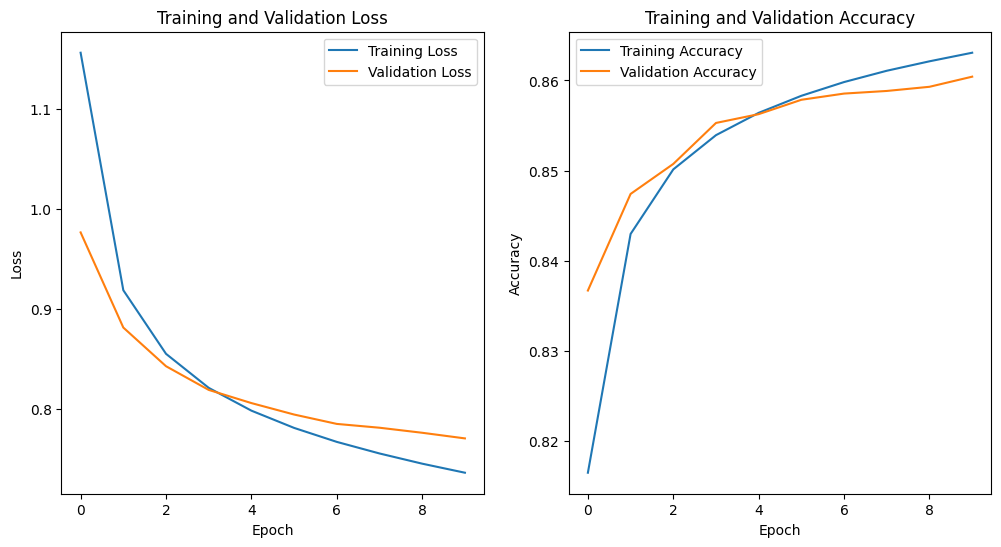

In [101]:
import matplotlib.pyplot as plt

# Extracting training loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracting validation loss
val_loss = history.history['val_loss']

# Extracting validation accuracy (if available)
val_accuracy = history.history.get('val_accuracy')

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy and validation accuracy (if available)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
if val_accuracy is not None:
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
else:
    plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [72]:
# train from checkpoint
model_chk = keras.models.load_model("models/10-0.75.h5",custom_objects={"AttentionLayer": AttentionLayer})
model_chk.compile(optimizer='rmsprop',
                      loss='sparse_categorical_crossentropy',
                      metrics=["accuracy"])


In [ ]:
#retraining model
history2 = model_chk.fit(
    [encoder_input_data_train, decoder_input_data_train],
    decoder_target_data_train,
    epochs=18,
    validation_data=([encoder_input_data_test,
                      decoder_input_data_test], decoder_target_data_test),
    callbacks=[checkpoint])

Epoch 1/18
4728/4728 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.8774
Epoch 1: saving model to models/01-0.75.h5
4728/4728 [==============================] - 506s 106ms/step - loss: 0.6192 - accuracy: 0.8774 - val_loss: 0.7512 - val_accuracy: 0.8628
Epoch 2/18
4728/4728 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.8778
Epoch 2: saving model to models/02-0.75.h5
4728/4728 [==============================] - 488s 103ms/step - loss: 0.6158 - accuracy: 0.8778 - val_loss: 0.7536 - val_accuracy: 0.8626
Epoch 3/18
4728/4728 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.8782
Epoch 3: saving model to models/03-0.76.h5
4728/4728 [==============================] - 487s 103ms/step - loss: 0.6125 - accuracy: 0.8782 - val_loss: 0.7559 - val_accuracy: 0.8614
Epoch 4/18
3043/4728 [==================>...........] - ETA: 2:46 - loss: 0.6066 - accuracy: 0.8790

In [ ]:
import matplotlib.pyplot as plt

# Extracting training loss and accuracy
train_loss = history2.history['loss']
train_accuracy = history2.history['accuracy']

# Extracting validation loss
val_loss = history2.history['val_loss']

# Extracting validation accuracy (if available)
val_accuracy = history2.history.get('val_accuracy')

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy and validation accuracy (if available)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
if val_accuracy is not None:
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
else:
    plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
#Load a saved model and run inference

In [73]:
loaded_model = keras.models.load_model("models/10-0.75.h5",custom_objects={"AttentionLayer": AttentionLayer})

In [74]:
#encoder inference model
encoder_inf_inputs = loaded_model.input[0]  # input_1
encoder_inf_output2,encoder_inf_state_h2, encoder_inf_state_c2 = loaded_model.layers[5].output
encoder_inf_model = Model(inputs=encoder_inf_inputs,outputs=[encoder_inf_output2,encoder_inf_state_h2, encoder_inf_state_c2])

In [75]:
# decoder inference model
decoder_inf_inputs = loaded_model.input[1]

encoder_out_temp = Input(shape=(40,latent_dim))
encoder_state_input_h = Input(shape=(latent_dim,))
encoder_state_input_c = Input(shape=(latent_dim,))

decoder_embed_layer = loaded_model.layers[4]
decoder_embeddings = decoder_embed_layer(decoder_inf_inputs)

decoder_inf_lstm = loaded_model.layers[6]
decoder_inf_outputs, decoder_state_h2, decoder_state_c2 = decoder_inf_lstm(decoder_embeddings, initial_state=[encoder_state_input_h, encoder_state_input_c])

# attention_inf_layer = loaded_model.layers[7], this is the attention model from the model but 
decoder_attention = loaded_model.layers[7]
attn_out_inf,_=decoder_attention([encoder_out_temp, decoder_inf_outputs])
# concat
decoder_inf_concat=tf.keras.layers.Concatenate()([decoder_inf_outputs, attn_out_inf])
# time_distributed
time = loaded_model.layers[9]
decoder_outputs2 = time(decoder_inf_concat)

decoder_model = Model(
inputs = [decoder_inf_inputs] + [encoder_out_temp,encoder_state_input_h, encoder_state_input_c],
outputs = [decoder_outputs2] + [decoder_state_h2, decoder_state_c2])

In [76]:
def prepare_text(text):
    # pad the text
    max_length = 40
    
    tokenized = word_tokenize(text)[:max_length]
    padded_text = tokenized + (max_length - len(tokenized)) * ["<padding>"]

    #initialising the training data
    encoder_input_data = np.zeros(
        (1, max_length),
        dtype='float32')
    
    for t, char in enumerate(padded_text):
        try:
            #use unk if we cant find the word in the dictionary
            encoder_input_data[0, t] = english_word_dict.get(
                char, english_word_dict["<unk>"])
        except:
            print(char)
    
    return encoder_input_data

In [77]:
sentence1 = "definitely share you feedback in the comment section"
sentence2 = "so even if its a big video, I will clearly mention all the products"
sentence3 = "I was waiting for my bag"

In [82]:
test = prepare_text(sentence3)

In [83]:
#encoding incoming data
e_out, e_h, e_c = encoder_inf_model.predict(test)
#creating target sequence
target_seq = np.zeros((1, 1))
#inputing start token
target_seq[0, 0] = english_word_dict['<s>']
stop_condition = False
decoded_sentence = ''
#looping until stop token is predicted or
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] +
                                                [e_out, e_h, e_c])
    #want to get index with highest probability
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #find word at that index
    sampled_char = hinglish_reversed_dict[sampled_token_index]
    #add to sentence
    decoded_sentence += ' ' + sampled_char
    if (sampled_char == "</s>" or len(word_tokenize(decoded_sentence)) > 52):
        stop_condition = True
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sampled_token_index
    #update hidden + cell states
    e_h, e_c = h, c

1/1 [==============================] - 0s 22ms/step


In [84]:
decoded_sentence

' kya aap muje remind kara sakte he to send my mom a birthday card on monday </s>'